In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [3]:
# implement data collection procedure on the RTBGym environment

# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [4]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [6]:
# standardized environment for discrete action
env = gym.make("RTBEnv-continuous-v0")
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [7]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    # n_steps=1000,
    # n_steps_per_epoch=10,
    # update_start_step=10,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)
# save model
sac.save_model("d3rlpy_logs/sac.pt")
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

2023-03-16 16:59.54 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230316165954
2023-03-16 16:59.54 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-16 16:59.54 [debug    ] Building model...
2023-03-16 16:59.54 [debug    ] Model has been built.
2023-03-16 16:59.54 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230316165954/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense'

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/100000 [00:00<?, ?it/s]

2023-03-16 16:59.55 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230316165954/model_1000.pt
2023-03-16 16:59.55 [info     ] SAC_online_20230316165954: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00034663939476013185, 'time_environment_step': 0.0003436546325683594, 'time_step': 0.000713925838470459, 'rollout_return': 4.535211267605634, 'evaluation': 0.0} step=1000
2023-03-16 16:59.59 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230316165954/model_2000.pt
2023-03-16 16:59.59 [info     ] SAC_online_20230316165954: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00034594893455505373, 'time_environment_step': 0.00040945792198181154, 'time_sample_batch': 0.00013985490798950197, 'time_algorithm_update': 0.0034187695980072022, 'temp_loss': -8.865488401412964, 'temp': 1.1656148592233657, 'critic_loss': 762.5420944519043, 'actor_loss': 7.192888723894954, 'time_step': 0.004348438024520874, 'rollout_return': 12.795774647887324, 'evaluat

In [8]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

In [9]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [10]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [56]:
# n_trajectories_list = [100, 200, 400]
# n_trajectories_list = [100, 200, 400, 800, 1600, 6400]
n_trajectories_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
# random_state_list = [10, 20, 30]
random_state_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

bias_df_list = []
variance_df_list = []


In [58]:

for n_trajectories in n_trajectories_list:
    cql_data = DataFrame()
    sac_data = DataFrame()
    for random_state in random_state_list:
    
        behavior_policy = TruncatedGaussianHead(
            sac, 
            minimum=env.action_space.low,
            maximum=env.action_space.high,
            sigma=np.array([1.0]),
            name="sac_sigma_1.0",
            random_state=random_state,
        )

        # initialize dataset class
        dataset = SyntheticDataset(
            env=env,
            state_keys=env.obs_keys,
            max_episode_steps=env.step_per_episode,
            info_keys={
                "search_volume": int,
                "impression": int,
                "click": int,
                "conversion": int,
                "average_bid_price": float,
            },
        )

        # collect logged data by a behavior policy
        # skip if there is a preserved logged dataset
        train_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=True,
            random_state=random_state,
        )
        test_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=True,
            random_state=random_state + 1,
        )

        # transform offline dataset for d3rlpy
        offlinerl_dataset = MDPDataset(
            observations=train_logged_dataset["state"],
            actions=train_logged_dataset["action"],
            rewards=train_logged_dataset["reward"],
            terminals=train_logged_dataset["done"],
            episode_terminals=train_logged_dataset["done"],
            discrete_action=False,
        )
        train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

        # # Use Conservative Q-Learning policy
        # cql = CQL(
        #     actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
        #     critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
        #     q_func_factory=MeanQFunctionFactory(),
        #     use_gpu=torch.cuda.is_available(),
        #     action_scaler=MinMaxActionScaler(
        #         minimum=env_.action_space.low,  # minimum value that policy can take
        #         maximum=env_.action_space.high,  # maximum value that policy can take
        #     )
        # )

        # cql.fit(
        #     train_episodes,
        #     eval_episodes=test_episodes,
        #     n_steps=10000,
        #     # n_steps=10000,
        #     scorers={},
        # )

        # # # save model
        # # cql.save_model("d3rlpy_logs/cql_continuous.pt")

        # # # reload model
        # # cql.build_with_env(env)
        # # cql.load_model("d3rlpy_logs/cql_continuous.pt")

        # # define evaluation policies (should be deterministic policy)
        # cql_ = ContinuousEvalHead(
        #     base_policy=cql,
        #     name="cql",
        # )
        sac_ = ContinuousEvalHead(
            base_policy=sac, 
            name="sac", 
        )
        evaluation_policies = [sac_]
        # evaluation_policies = [cql_, sac_]
        
        # first, prepare OPE inputs
        prep = CreateOPEInput(
            env=env,
            model_args={
                "fqe": {
                    "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
                    "q_func_factory": MeanQFunctionFactory(),
                    "learning_rate": 1e-4,
                    "use_gpu": torch.cuda.is_available(),
                },
            },
            state_scaler=MinMaxScaler(
                minimum=test_logged_dataset["state"].min(axis=0),
                maximum=test_logged_dataset["state"].max(axis=0),
            ),
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            gamma=0.95,
            sigma=0.1,
            device="cuda:0" if torch.cuda.is_available() else "cpu",
        )

        # takes time
        input_dict = prep.obtain_whole_inputs(
            logged_dataset=test_logged_dataset,
            evaluation_policies=evaluation_policies,
            require_value_prediction=True,
            require_weight_prediction=True,
            n_trajectories_on_policy_evaluation=100,
            random_state=random_state,
        )

        ope = OPE(
            logged_dataset=test_logged_dataset,
            ope_estimators=all_estimators,
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            sigma=0.1,
        )

        policy_value_dict = ope.estimate_policy_value(
            input_dict=input_dict,
        )
        
        # tmp_cql = DataFrame(policy_value_dict)['cql']
        # cql_data = pd.concat([cql_data, tmp_cql], axis=1)
        tmp_sac = DataFrame(policy_value_dict)['sac']
        sac_data = pd.concat([sac_data, tmp_sac], axis=1)
        
        
    bias = abs(sac_data.mean(axis=1) - sac_data.mean(axis=1)['on_policy'])
    variance = sac_data.var(axis=1)
    # bias = abs(cql_data.mean(axis=1) - cql_data.mean(axis=1)['on_policy'])
    # variance = cql_data.var(axis=1)

    bias_df = DataFrame(DataFrame(bias).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "bias"})
    bias_df["n_trajectories"] = n_trajectories
    bias_df_list.append(bias_df)
    
    variance_df = DataFrame(DataFrame(variance).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "variance"})
    variance_df["n_trajectories"] = n_trajectories
    variance_df_list.append(variance_df)

# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:40.28 [debug    ] RoundIterator is selected.
2023-03-16 18:40.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184028
2023-03-16 18:40.28 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:40.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:40.28 [debug    ] Building models...
2023-03-16 18:40.28 [debug    ] Models have been built.
2023-03-16 18:40.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184028/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:40.28 [info     ] FQE_20230316184028: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00012833731515066965, 'time_algorithm_update': 0.001967634473528181, 'loss': 14.961320195879255, 'time_step': 0.0021568025861467633} step=7
2023-03-16 18:40.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184028/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:40.50 [debug    ] RoundIterator is selected.
2023-03-16 18:40.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184050
2023-03-16 18:40.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:40.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:40.50 [debug    ] Building models...
2023-03-16 18:40.50 [debug    ] Models have been built.
2023-03-16 18:40.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184050/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:40.50 [info     ] FQE_20230316184050: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 7.486343383789062e-05, 'time_algorithm_update': 0.0014324869428362166, 'loss': 13.180279323032924, 'time_step': 0.0015523433685302734} step=7
2023-03-16 18:40.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184050/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:41.10 [debug    ] RoundIterator is selected.
2023-03-16 18:41.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184110
2023-03-16 18:41.10 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:41.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:41.10 [debug    ] Building models...
2023-03-16 18:41.10 [debug    ] Models have been built.
2023-03-16 18:41.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184110/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:41.10 [info     ] FQE_20230316184110: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00012867791312081472, 'time_algorithm_update': 0.0020279884338378906, 'loss': 15.192714009966169, 'time_step': 0.0022065298897879465} step=7
2023-03-16 18:41.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184110/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:41.29 [debug    ] RoundIterator is selected.
2023-03-16 18:41.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184129
2023-03-16 18:41.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:41.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:41.29 [debug    ] Building models...
2023-03-16 18:41.29 [debug    ] Models have been built.
2023-03-16 18:41.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184129/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:41.30 [info     ] FQE_20230316184129: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00010326930454799108, 'time_algorithm_update': 0.0019310542515345982, 'loss': 12.915191105433873, 'time_step': 0.002087967736380441} step=7
2023-03-16 18:41.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184129/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:41.50 [debug    ] RoundIterator is selected.
2023-03-16 18:41.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184150
2023-03-16 18:41.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:41.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:41.50 [debug    ] Building models...
2023-03-16 18:41.50 [debug    ] Models have been built.
2023-03-16 18:41.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184150/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:41.50 [info     ] FQE_20230316184150: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 9.809221540178572e-05, 'time_algorithm_update': 0.0019038404737200057, 'loss': 15.5904449735369, 'time_step': 0.0020603452410016742} step=7
2023-03-16 18:41.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184150/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:42.12 [debug    ] RoundIterator is selected.
2023-03-16 18:42.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184212
2023-03-16 18:42.12 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:42.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:42.12 [debug    ] Building models...
2023-03-16 18:42.12 [debug    ] Models have been built.
2023-03-16 18:42.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184212/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:42.12 [info     ] FQE_20230316184212: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00010456357683454241, 'time_algorithm_update': 0.002069371087210519, 'loss': 13.260228293282646, 'time_step': 0.00225240843636649} step=7
2023-03-16 18:42.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184212/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:42.34 [debug    ] RoundIterator is selected.
2023-03-16 18:42.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184234
2023-03-16 18:42.34 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:42.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:42.34 [debug    ] Building models...
2023-03-16 18:42.34 [debug    ] Models have been built.
2023-03-16 18:42.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184234/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:42.34 [info     ] FQE_20230316184234: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 7.448877607073103e-05, 'time_algorithm_update': 0.0016515595572335379, 'loss': 12.143428938729423, 'time_step': 0.0017854486192975725} step=7
2023-03-16 18:42.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184234/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:42.56 [debug    ] RoundIterator is selected.
2023-03-16 18:42.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184256
2023-03-16 18:42.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:42.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:42.56 [debug    ] Building models...
2023-03-16 18:42.56 [debug    ] Models have been built.
2023-03-16 18:42.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184256/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:42.56 [info     ] FQE_20230316184256: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00011784689767020089, 'time_algorithm_update': 0.00217611449105399, 'loss': 11.759752137320381, 'time_step': 0.00237621579851423} step=7
2023-03-16 18:42.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184256/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:43.17 [debug    ] RoundIterator is selected.
2023-03-16 18:43.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184317
2023-03-16 18:43.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:43.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:43.17 [debug    ] Building models...
2023-03-16 18:43.17 [debug    ] Models have been built.
2023-03-16 18:43.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184317/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:43.17 [info     ] FQE_20230316184317: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 0.00011771065848214286, 'time_algorithm_update': 0.0021513530186244418, 'loss': 13.07062476021903, 'time_step': 0.0023238658905029297} step=7
2023-03-16 18:43.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184317/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:43.39 [debug    ] RoundIterator is selected.
2023-03-16 18:43.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184339
2023-03-16 18:43.39 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:43.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:43.39 [debug    ] Building models...
2023-03-16 18:43.39 [debug    ] Models have been built.
2023-03-16 18:43.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184339/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-16 18:43.39 [info     ] FQE_20230316184339: epoch=1 step=7 epoch=1 metrics={'time_sample_batch': 8.855547223772322e-05, 'time_algorithm_update': 0.0014602456774030412, 'loss': 13.773944309779576, 'time_step': 0.001600095203944615} step=7
2023-03-16 18:43.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184339/model_7.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:44.00 [debug    ] RoundIterator is selected.
2023-03-16 18:44.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184400
2023-03-16 18:44.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:44.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:44.00 [debug    ] Building models...
2023-03-16 18:44.00 [debug    ] Models have been built.
2023-03-16 18:44.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184400/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:44.00 [info     ] FQE_20230316184400: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 7.826941353934152e-05, 'time_algorithm_update': 0.0015471151896885463, 'loss': 14.047036443437849, 'time_step': 0.0016831329890659877} step=14
2023-03-16 18:44.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184400/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:44.22 [debug    ] RoundIterator is selected.
2023-03-16 18:44.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184422
2023-03-16 18:44.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:44.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:44.22 [debug    ] Building models...
2023-03-16 18:44.22 [debug    ] Models have been built.
2023-03-16 18:44.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184422/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:44.22 [info     ] FQE_20230316184422: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 0.00011188643319266183, 'time_algorithm_update': 0.0014109270913260324, 'loss': 13.301973581314087, 'time_step': 0.001581566674368722} step=14
2023-03-16 18:44.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184422/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:44.44 [debug    ] RoundIterator is selected.
2023-03-16 18:44.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184444
2023-03-16 18:44.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:44.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:44.44 [debug    ] Building models...
2023-03-16 18:44.44 [debug    ] Models have been built.
2023-03-16 18:44.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184444/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:44.44 [info     ] FQE_20230316184444: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 0.00016198839460100447, 'time_algorithm_update': 0.0021853617259434293, 'loss': 14.948265007564, 'time_step': 0.0024490697043282644} step=14
2023-03-16 18:44.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184444/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:45.07 [debug    ] RoundIterator is selected.
2023-03-16 18:45.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184507
2023-03-16 18:45.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:45.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:45.07 [debug    ] Building models...
2023-03-16 18:45.07 [debug    ] Models have been built.
2023-03-16 18:45.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184507/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:45.07 [info     ] FQE_20230316184507: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 8.000646318708147e-05, 'time_algorithm_update': 0.0011047976357596262, 'loss': 13.137981380735125, 'time_step': 0.0012166500091552734} step=14
2023-03-16 18:45.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184507/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:45.30 [debug    ] RoundIterator is selected.
2023-03-16 18:45.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184530
2023-03-16 18:45.30 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:45.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:45.30 [debug    ] Building models...
2023-03-16 18:45.30 [debug    ] Models have been built.
2023-03-16 18:45.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184530/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:45.30 [info     ] FQE_20230316184530: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 7.724761962890625e-05, 'time_algorithm_update': 0.001519049916948591, 'loss': 14.851514884403773, 'time_step': 0.0016632590975080217} step=14
2023-03-16 18:45.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184530/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:45.52 [debug    ] RoundIterator is selected.
2023-03-16 18:45.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184552
2023-03-16 18:45.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:45.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:45.52 [debug    ] Building models...
2023-03-16 18:45.52 [debug    ] Models have been built.
2023-03-16 18:45.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184552/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:45.52 [info     ] FQE_20230316184552: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 9.620189666748047e-05, 'time_algorithm_update': 0.001726576260157994, 'loss': 13.174466746194023, 'time_step': 0.0019002982548304967} step=14
2023-03-16 18:45.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184552/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:46.16 [debug    ] RoundIterator is selected.
2023-03-16 18:46.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184616
2023-03-16 18:46.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:46.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:46.16 [debug    ] Building models...
2023-03-16 18:46.16 [debug    ] Models have been built.
2023-03-16 18:46.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184616/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:46.16 [info     ] FQE_20230316184616: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 9.654249463762556e-05, 'time_algorithm_update': 0.0012030431202479772, 'loss': 12.72965955734253, 'time_step': 0.0013719967433384486} step=14
2023-03-16 18:46.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184616/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:46.40 [debug    ] RoundIterator is selected.
2023-03-16 18:46.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184640
2023-03-16 18:46.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:46.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:46.40 [debug    ] Building models...
2023-03-16 18:46.40 [debug    ] Models have been built.
2023-03-16 18:46.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184640/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:46.40 [info     ] FQE_20230316184640: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 0.00010277543749128069, 'time_algorithm_update': 0.0013984271458217076, 'loss': 12.573896203722272, 'time_step': 0.0015565156936645508} step=14
2023-03-16 18:46.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184640/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:47.03 [debug    ] RoundIterator is selected.
2023-03-16 18:47.03 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184703
2023-03-16 18:47.03 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:47.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:47.03 [debug    ] Building models...
2023-03-16 18:47.03 [debug    ] Models have been built.
2023-03-16 18:47.03 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184703/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:47.03 [info     ] FQE_20230316184703: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 0.00012859276362827847, 'time_algorithm_update': 0.0016202926635742188, 'loss': 12.703236171177455, 'time_step': 0.0018235955919538225} step=14
2023-03-16 18:47.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184703/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:47.26 [debug    ] RoundIterator is selected.
2023-03-16 18:47.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184726
2023-03-16 18:47.26 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:47.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:47.26 [debug    ] Building models...
2023-03-16 18:47.26 [debug    ] Models have been built.
2023-03-16 18:47.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184726/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-16 18:47.26 [info     ] FQE_20230316184726: epoch=1 step=14 epoch=1 metrics={'time_sample_batch': 8.84873526436942e-05, 'time_algorithm_update': 0.0013061250959123885, 'loss': 13.678116934640068, 'time_step': 0.0014601094382149832} step=14
2023-03-16 18:47.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184726/model_14.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:47.52 [debug    ] RoundIterator is selected.
2023-03-16 18:47.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184752
2023-03-16 18:47.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:47.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:47.52 [debug    ] Building models...
2023-03-16 18:47.52 [debug    ] Models have been built.
2023-03-16 18:47.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184752/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:47.52 [info     ] FQE_20230316184752: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.17349978855678e-05, 'time_algorithm_update': 0.0012530514172145299, 'loss': 13.378277676446098, 'time_step': 0.00137850216456822} step=28
2023-03-16 18:47.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184752/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:48.17 [debug    ] RoundIterator is selected.
2023-03-16 18:48.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184817
2023-03-16 18:48.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:48.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:48.17 [debug    ] Building models...
2023-03-16 18:48.17 [debug    ] Models have been built.
2023-03-16 18:48.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184817/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:48.17 [info     ] FQE_20230316184817: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 9.015628269740514e-05, 'time_algorithm_update': 0.0012679100036621094, 'loss': 12.885343636785235, 'time_step': 0.0014042002814156668} step=28
2023-03-16 18:48.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184817/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:48.42 [debug    ] RoundIterator is selected.
2023-03-16 18:48.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184842
2023-03-16 18:48.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:48.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:48.42 [debug    ] Building models...
2023-03-16 18:48.42 [debug    ] Models have been built.
2023-03-16 18:48.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184842/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:48.42 [info     ] FQE_20230316184842: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 7.975101470947266e-05, 'time_algorithm_update': 0.0011669567653111049, 'loss': 14.215324980872017, 'time_step': 0.0012892484664916992} step=28
2023-03-16 18:48.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184842/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:49.07 [debug    ] RoundIterator is selected.
2023-03-16 18:49.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184907
2023-03-16 18:49.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:49.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:49.07 [debug    ] Building models...
2023-03-16 18:49.07 [debug    ] Models have been built.
2023-03-16 18:49.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184907/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:49.07 [info     ] FQE_20230316184907: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.358274187360491e-05, 'time_algorithm_update': 0.0012456348964146205, 'loss': 13.38482117652893, 'time_step': 0.001367006983075823} step=28
2023-03-16 18:49.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184907/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:49.32 [debug    ] RoundIterator is selected.
2023-03-16 18:49.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184932
2023-03-16 18:49.32 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:49.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:49.32 [debug    ] Building models...
2023-03-16 18:49.32 [debug    ] Models have been built.
2023-03-16 18:49.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184932/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:49.32 [info     ] FQE_20230316184932: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.050033024379186e-05, 'time_algorithm_update': 0.0012393849236624582, 'loss': 14.541827372142247, 'time_step': 0.001360935824257987} step=28
2023-03-16 18:49.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184932/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:49.57 [debug    ] RoundIterator is selected.
2023-03-16 18:49.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230316184957
2023-03-16 18:49.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:49.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:49.57 [debug    ] Building models...
2023-03-16 18:49.57 [debug    ] Models have been built.
2023-03-16 18:49.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316184957/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:49.57 [info     ] FQE_20230316184957: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 7.752009800502233e-05, 'time_algorithm_update': 0.0012396488870893205, 'loss': 12.832355431147985, 'time_step': 0.0013604845319475447} step=28
2023-03-16 18:49.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316184957/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:50.22 [debug    ] RoundIterator is selected.
2023-03-16 18:50.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185022
2023-03-16 18:50.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:50.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:50.22 [debug    ] Building models...
2023-03-16 18:50.22 [debug    ] Models have been built.
2023-03-16 18:50.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185022/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:50.22 [info     ] FQE_20230316185022: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.697169167654855e-05, 'time_algorithm_update': 0.0012142998831612723, 'loss': 12.87952721118927, 'time_step': 0.001354191984449114} step=28
2023-03-16 18:50.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185022/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:50.48 [debug    ] RoundIterator is selected.
2023-03-16 18:50.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185048
2023-03-16 18:50.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:50.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:50.48 [debug    ] Building models...
2023-03-16 18:50.48 [debug    ] Models have been built.
2023-03-16 18:50.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185048/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:50.48 [info     ] FQE_20230316185048: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.541345596313477e-05, 'time_algorithm_update': 0.0013637031827654158, 'loss': 12.951234596116203, 'time_step': 0.001507171562739781} step=28
2023-03-16 18:50.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185048/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:51.13 [debug    ] RoundIterator is selected.
2023-03-16 18:51.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185113
2023-03-16 18:51.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:51.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:51.13 [debug    ] Building models...
2023-03-16 18:51.13 [debug    ] Models have been built.
2023-03-16 18:51.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185113/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:51.13 [info     ] FQE_20230316185113: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 9.532485689435686e-05, 'time_algorithm_update': 0.0012208308492388045, 'loss': 13.317390424864632, 'time_step': 0.0013626047543116979} step=28
2023-03-16 18:51.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185113/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:51.38 [debug    ] RoundIterator is selected.
2023-03-16 18:51.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185138
2023-03-16 18:51.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:51.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:51.38 [debug    ] Building models...
2023-03-16 18:51.38 [debug    ] Models have been built.
2023-03-16 18:51.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185138/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/28 [00:00<?, ?it/s]

2023-03-16 18:51.38 [info     ] FQE_20230316185138: epoch=1 step=28 epoch=1 metrics={'time_sample_batch': 8.652891431535994e-05, 'time_algorithm_update': 0.0012641378811427525, 'loss': 13.772294555391584, 'time_step': 0.001407921314239502} step=28
2023-03-16 18:51.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185138/model_28.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:52.08 [debug    ] RoundIterator is selected.
2023-03-16 18:52.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185208
2023-03-16 18:52.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:52.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:52.08 [debug    ] Building models...
2023-03-16 18:52.08 [debug    ] Models have been built.
2023-03-16 18:52.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185208/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:52.08 [info     ] FQE_20230316185208: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.403829165867396e-05, 'time_algorithm_update': 0.0010544955730438232, 'loss': 13.643654210226876, 'time_step': 0.0011842421122959682} step=56
2023-03-16 18:52.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185208/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:52.38 [debug    ] RoundIterator is selected.
2023-03-16 18:52.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185238
2023-03-16 18:52.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:52.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:52.38 [debug    ] Building models...
2023-03-16 18:52.38 [debug    ] Models have been built.
2023-03-16 18:52.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185238/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:52.38 [info     ] FQE_20230316185238: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.678010531834193e-05, 'time_algorithm_update': 0.0010766727583748953, 'loss': 12.829245030879974, 'time_step': 0.001203958477292742} step=56
2023-03-16 18:52.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185238/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:53.07 [debug    ] RoundIterator is selected.
2023-03-16 18:53.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185307
2023-03-16 18:53.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:53.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:53.07 [debug    ] Building models...
2023-03-16 18:53.07 [debug    ] Models have been built.
2023-03-16 18:53.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185307/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:53.07 [info     ] FQE_20230316185307: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.818932941981725e-05, 'time_algorithm_update': 0.001039517777306693, 'loss': 14.09229472705296, 'time_step': 0.0011694346155439103} step=56
2023-03-16 18:53.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185307/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:53.37 [debug    ] RoundIterator is selected.
2023-03-16 18:53.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185337
2023-03-16 18:53.37 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:53.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:53.37 [debug    ] Building models...
2023-03-16 18:53.37 [debug    ] Models have been built.
2023-03-16 18:53.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185337/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:53.37 [info     ] FQE_20230316185337: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.53921685900007e-05, 'time_algorithm_update': 0.0010485138211931502, 'loss': 13.026208979742867, 'time_step': 0.0011760933058602469} step=56
2023-03-16 18:53.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185337/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:54.07 [debug    ] RoundIterator is selected.
2023-03-16 18:54.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185407
2023-03-16 18:54.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:54.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:54.07 [debug    ] Building models...
2023-03-16 18:54.07 [debug    ] Models have been built.
2023-03-16 18:54.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185407/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:54.07 [info     ] FQE_20230316185407: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.961984089442662e-05, 'time_algorithm_update': 0.0010444649628230504, 'loss': 13.955668457916804, 'time_step': 0.0011737346649169922} step=56
2023-03-16 18:54.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185407/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:54.40 [debug    ] RoundIterator is selected.
2023-03-16 18:54.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185440
2023-03-16 18:54.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:54.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:54.40 [debug    ] Building models...
2023-03-16 18:54.40 [debug    ] Models have been built.
2023-03-16 18:54.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185440/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:54.40 [info     ] FQE_20230316185440: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.156044142586845e-05, 'time_algorithm_update': 0.0010984625135149275, 'loss': 12.645907163619995, 'time_step': 0.0012269956724984305} step=56
2023-03-16 18:54.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185440/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:55.11 [debug    ] RoundIterator is selected.
2023-03-16 18:55.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185511
2023-03-16 18:55.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:55.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:55.11 [debug    ] Building models...
2023-03-16 18:55.11 [debug    ] Models have been built.
2023-03-16 18:55.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185511/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:55.11 [info     ] FQE_20230316185511: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.440869195120675e-05, 'time_algorithm_update': 0.0010801851749420166, 'loss': 13.176154119627816, 'time_step': 0.001216799020767212} step=56
2023-03-16 18:55.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185511/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:55.42 [debug    ] RoundIterator is selected.
2023-03-16 18:55.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185542
2023-03-16 18:55.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:55.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:55.42 [debug    ] Building models...
2023-03-16 18:55.42 [debug    ] Models have been built.
2023-03-16 18:55.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185542/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:55.43 [info     ] FQE_20230316185542: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.328471864972795e-05, 'time_algorithm_update': 0.0010416252272469656, 'loss': 12.862339845725469, 'time_step': 0.0011741859572274344} step=56
2023-03-16 18:55.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185542/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:56.14 [debug    ] RoundIterator is selected.
2023-03-16 18:56.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185614
2023-03-16 18:56.14 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:56.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:56.14 [debug    ] Building models...
2023-03-16 18:56.14 [debug    ] Models have been built.
2023-03-16 18:56.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185614/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:56.14 [info     ] FQE_20230316185614: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 9.125045367649623e-05, 'time_algorithm_update': 0.0010905180658612932, 'loss': 13.302642047405243, 'time_step': 0.001227485282080514} step=56
2023-03-16 18:56.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185614/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:56.45 [debug    ] RoundIterator is selected.
2023-03-16 18:56.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185645
2023-03-16 18:56.45 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:56.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:56.45 [debug    ] Building models...
2023-03-16 18:56.45 [debug    ] Models have been built.
2023-03-16 18:56.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185645/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/56 [00:00<?, ?it/s]

2023-03-16 18:56.45 [info     ] FQE_20230316185645: epoch=1 step=56 epoch=1 metrics={'time_sample_batch': 8.653742926461356e-05, 'time_algorithm_update': 0.0010543337890080043, 'loss': 13.75250666482108, 'time_step': 0.0011896065303257533} step=56
2023-03-16 18:56.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185645/model_56.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:57.28 [debug    ] RoundIterator is selected.
2023-03-16 18:57.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185728
2023-03-16 18:57.28 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:57.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:57.28 [debug    ] Building models...
2023-03-16 18:57.28 [debug    ] Models have been built.
2023-03-16 18:57.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185728/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 18:57.28 [info     ] FQE_20230316185728: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 9.001578603472029e-05, 'time_algorithm_update': 0.001023914132799421, 'loss': 13.673989049025945, 'time_step': 0.0011555467333112443} step=112
2023-03-16 18:57.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185728/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:58.11 [debug    ] RoundIterator is selected.
2023-03-16 18:58.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185811
2023-03-16 18:58.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:58.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:58.11 [debug    ] Building models...
2023-03-16 18:58.11 [debug    ] Models have been built.
2023-03-16 18:58.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185811/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 18:58.11 [info     ] FQE_20230316185811: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.991360664367676e-05, 'time_algorithm_update': 0.0010141623871667044, 'loss': 12.618497959205083, 'time_step': 0.0011445369039263045} step=112
2023-03-16 18:58.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185811/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:58.54 [debug    ] RoundIterator is selected.
2023-03-16 18:58.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185854
2023-03-16 18:58.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:58.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:58.54 [debug    ] Building models...
2023-03-16 18:58.54 [debug    ] Models have been built.
2023-03-16 18:58.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185854/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 18:58.54 [info     ] FQE_20230316185854: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.26120376586914e-05, 'time_algorithm_update': 0.0010018753153937204, 'loss': 14.328841452087675, 'time_step': 0.0011262659515653337} step=112
2023-03-16 18:58.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185854/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 18:59.36 [debug    ] RoundIterator is selected.
2023-03-16 18:59.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230316185936
2023-03-16 18:59.36 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 18:59.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 18:59.36 [debug    ] Building models...
2023-03-16 18:59.36 [debug    ] Models have been built.
2023-03-16 18:59.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316185936/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 18:59.36 [info     ] FQE_20230316185936: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.904082434517997e-05, 'time_algorithm_update': 0.0010143199137278966, 'loss': 13.428848888192858, 'time_step': 0.0011476831776755197} step=112
2023-03-16 18:59.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316185936/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:00.19 [debug    ] RoundIterator is selected.
2023-03-16 19:00.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190019
2023-03-16 19:00.19 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:00.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:00.19 [debug    ] Building models...
2023-03-16 19:00.19 [debug    ] Models have been built.
2023-03-16 19:00.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190019/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 19:00.19 [info     ] FQE_20230316190019: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.537726742880685e-05, 'time_algorithm_update': 0.0010426661797932216, 'loss': 14.136255289827075, 'time_step': 0.0011679274695260184} step=112
2023-03-16 19:00.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190019/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:01.02 [debug    ] RoundIterator is selected.
2023-03-16 19:01.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190102
2023-03-16 19:01.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:01.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:01.02 [debug    ] Building models...
2023-03-16 19:01.02 [debug    ] Models have been built.
2023-03-16 19:01.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190102/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 19:01.03 [info     ] FQE_20230316190102: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 9.146119867052351e-05, 'time_algorithm_update': 0.0010474281651633127, 'loss': 13.009017114128385, 'time_step': 0.0011810937098094396} step=112
2023-03-16 19:01.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190102/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:01.46 [debug    ] RoundIterator is selected.
2023-03-16 19:01.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190146
2023-03-16 19:01.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:01.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:01.46 [debug    ] Building models...
2023-03-16 19:01.46 [debug    ] Models have been built.
2023-03-16 19:01.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190146/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 19:01.46 [info     ] FQE_20230316190146: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.32357576915196e-05, 'time_algorithm_update': 0.001003976379122053, 'loss': 12.92544402394976, 'time_step': 0.0011234602757862636} step=112
2023-03-16 19:01.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190146/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:02.31 [debug    ] RoundIterator is selected.
2023-03-16 19:02.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190231
2023-03-16 19:02.31 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:02.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:02.31 [debug    ] Building models...
2023-03-16 19:02.32 [debug    ] Models have been built.
2023-03-16 19:02.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190231/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 19:02.32 [info     ] FQE_20230316190231: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.728674479893275e-05, 'time_algorithm_update': 0.0010465319667543685, 'loss': 12.817905549492155, 'time_step': 0.0011755994388035365} step=112
2023-03-16 19:02.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190231/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:03.13 [debug    ] RoundIterator is selected.
2023-03-16 19:03.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190313
2023-03-16 19:03.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:03.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:03.13 [debug    ] Building models...
2023-03-16 19:03.13 [debug    ] Models have been built.
2023-03-16 19:03.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190313/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 19:03.13 [info     ] FQE_20230316190313: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.152212415422712e-05, 'time_algorithm_update': 0.0009604543447494507, 'loss': 13.015097937413625, 'time_step': 0.0010803427015032088} step=112
2023-03-16 19:03.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190313/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:03.55 [debug    ] RoundIterator is selected.
2023-03-16 19:03.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190355
2023-03-16 19:03.55 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:03.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:03.55 [debug    ] Building models...
2023-03-16 19:03.55 [debug    ] Models have been built.
2023-03-16 19:03.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190355/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/112 [00:00<?, ?it/s]

2023-03-16 19:03.55 [info     ] FQE_20230316190355: epoch=1 step=112 epoch=1 metrics={'time_sample_batch': 8.713347571236747e-05, 'time_algorithm_update': 0.0010520134653363908, 'loss': 13.760155975818634, 'time_step': 0.0011776536703109741} step=112
2023-03-16 19:03.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190355/model_112.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:04.58 [debug    ] RoundIterator is selected.
2023-03-16 19:04.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190458
2023-03-16 19:04.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:04.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:04.58 [debug    ] Building models...
2023-03-16 19:04.58 [debug    ] Models have been built.
2023-03-16 19:04.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190458/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:04.58 [info     ] FQE_20230316190458: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 9.101842130933489e-05, 'time_algorithm_update': 0.0009685105511120387, 'loss': 14.11035389133862, 'time_step': 0.0011008658579417638} step=224
2023-03-16 19:04.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190458/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:06.00 [debug    ] RoundIterator is selected.
2023-03-16 19:06.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190600
2023-03-16 19:06.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:06.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:06.00 [debug    ] Building models...
2023-03-16 19:06.00 [debug    ] Models have been built.
2023-03-16 19:06.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190600/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:06.01 [info     ] FQE_20230316190600: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 8.690037897654943e-05, 'time_algorithm_update': 0.0009846857615879603, 'loss': 13.201243260077067, 'time_step': 0.001114519579069955} step=224
2023-03-16 19:06.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190600/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:07.04 [debug    ] RoundIterator is selected.
2023-03-16 19:07.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190704
2023-03-16 19:07.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:07.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:07.04 [debug    ] Building models...
2023-03-16 19:07.04 [debug    ] Models have been built.
2023-03-16 19:07.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190704/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:07.04 [info     ] FQE_20230316190704: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 8.37360109601702e-05, 'time_algorithm_update': 0.0009065366217068263, 'loss': 14.90804431268147, 'time_step': 0.0010250923889023916} step=224
2023-03-16 19:07.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190704/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:08.05 [debug    ] RoundIterator is selected.
2023-03-16 19:08.05 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190805
2023-03-16 19:08.05 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:08.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:08.05 [debug    ] Building models...
2023-03-16 19:08.05 [debug    ] Models have been built.
2023-03-16 19:08.05 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190805/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:08.05 [info     ] FQE_20230316190805: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 8.54847686631339e-05, 'time_algorithm_update': 0.0009480469993182591, 'loss': 13.743461198040418, 'time_step': 0.0010698969875063216} step=224
2023-03-16 19:08.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190805/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:09.08 [debug    ] RoundIterator is selected.
2023-03-16 19:09.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230316190908
2023-03-16 19:09.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:09.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:09.08 [debug    ] Building models...
2023-03-16 19:09.08 [debug    ] Models have been built.
2023-03-16 19:09.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316190908/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:09.08 [info     ] FQE_20230316190908: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 8.480570146015712e-05, 'time_algorithm_update': 0.0009050635354859489, 'loss': 14.53686533655439, 'time_step': 0.0010291401829038347} step=224
2023-03-16 19:09.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316190908/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:10.09 [debug    ] RoundIterator is selected.
2023-03-16 19:10.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230316191009
2023-03-16 19:10.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:10.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:10.09 [debug    ] Building models...
2023-03-16 19:10.09 [debug    ] Models have been built.
2023-03-16 19:10.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316191009/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:10.09 [info     ] FQE_20230316191009: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 9.199764047350203e-05, 'time_algorithm_update': 0.0010286856974874223, 'loss': 13.559736145394188, 'time_step': 0.00115764353956495} step=224
2023-03-16 19:10.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316191009/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:11.18 [debug    ] RoundIterator is selected.
2023-03-16 19:11.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230316191118
2023-03-16 19:11.18 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:11.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:11.18 [debug    ] Building models...
2023-03-16 19:11.18 [debug    ] Models have been built.
2023-03-16 19:11.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316191118/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:11.18 [info     ] FQE_20230316191118: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 9.41476651600429e-05, 'time_algorithm_update': 0.0010145572679383414, 'loss': 13.307140246033669, 'time_step': 0.0011506229639053345} step=224
2023-03-16 19:11.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316191118/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:12.24 [debug    ] RoundIterator is selected.
2023-03-16 19:12.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230316191224
2023-03-16 19:12.24 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:12.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:12.24 [debug    ] Building models...
2023-03-16 19:12.24 [debug    ] Models have been built.
2023-03-16 19:12.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316191224/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:12.24 [info     ] FQE_20230316191224: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 9.076084409441267e-05, 'time_algorithm_update': 0.0010245548827307565, 'loss': 13.615849135177475, 'time_step': 0.0011518682752336775} step=224
2023-03-16 19:12.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316191224/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:13.29 [debug    ] RoundIterator is selected.
2023-03-16 19:13.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230316191329
2023-03-16 19:13.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:13.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:13.29 [debug    ] Building models...
2023-03-16 19:13.29 [debug    ] Models have been built.
2023-03-16 19:13.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316191329/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:13.30 [info     ] FQE_20230316191329: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 9.881279298237391e-05, 'time_algorithm_update': 0.0011396589023726328, 'loss': 13.159603063549314, 'time_step': 0.0012781013335500444} step=224
2023-03-16 19:13.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316191329/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:14.37 [debug    ] RoundIterator is selected.
2023-03-16 19:14.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230316191437
2023-03-16 19:14.37 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:14.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:14.37 [debug    ] Building models...
2023-03-16 19:14.37 [debug    ] Models have been built.
2023-03-16 19:14.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316191437/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/224 [00:00<?, ?it/s]

2023-03-16 19:14.37 [info     ] FQE_20230316191437: epoch=1 step=224 epoch=1 metrics={'time_sample_batch': 9.794746126447405e-05, 'time_algorithm_update': 0.0011599021298544748, 'loss': 14.056146517395973, 'time_step': 0.0013108679226466588} step=224
2023-03-16 19:14.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316191437/model_224.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:16.27 [debug    ] RoundIterator is selected.
2023-03-16 19:16.27 [info     ] Directory is created at d3rlpy_logs/FQE_20230316191627
2023-03-16 19:16.27 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:16.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:16.27 [debug    ] Building models...
2023-03-16 19:16.27 [debug    ] Models have been built.
2023-03-16 19:16.27 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316191627/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:16.28 [info     ] FQE_20230316191627: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.031008396829878e-05, 'time_algorithm_update': 0.0009553624050957816, 'loss': 16.161272404449328, 'time_step': 0.0010849109717777797} step=448
2023-03-16 19:16.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316191627/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:18.12 [debug    ] RoundIterator is selected.
2023-03-16 19:18.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230316191812
2023-03-16 19:18.12 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:18.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:18.12 [debug    ] Building models...
2023-03-16 19:18.12 [debug    ] Models have been built.
2023-03-16 19:18.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316191812/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:18.12 [info     ] FQE_20230316191812: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.21312187399183e-05, 'time_algorithm_update': 0.0009556801191398076, 'loss': 16.463231928646564, 'time_step': 0.0010877459176949092} step=448
2023-03-16 19:18.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316191812/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:19.58 [debug    ] RoundIterator is selected.
2023-03-16 19:19.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230316191958
2023-03-16 19:19.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:19.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:19.58 [debug    ] Building models...
2023-03-16 19:19.58 [debug    ] Models have been built.
2023-03-16 19:19.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316191958/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:19.59 [info     ] FQE_20230316191958: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 0.0001099221408367157, 'time_algorithm_update': 0.0012143217027187347, 'loss': 18.06610560523612, 'time_step': 0.0013781450688838959} step=448
2023-03-16 19:19.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316191958/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:21.44 [debug    ] RoundIterator is selected.
2023-03-16 19:21.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230316192144
2023-03-16 19:21.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:21.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:21.44 [debug    ] Building models...
2023-03-16 19:21.44 [debug    ] Models have been built.
2023-03-16 19:21.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316192144/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:21.45 [info     ] FQE_20230316192144: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.445313896451677e-05, 'time_algorithm_update': 0.000958551253591265, 'loss': 15.907000961048263, 'time_step': 0.0010933737669672286} step=448
2023-03-16 19:21.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316192144/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:23.29 [debug    ] RoundIterator is selected.
2023-03-16 19:23.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230316192329
2023-03-16 19:23.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:23.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:23.29 [debug    ] Building models...
2023-03-16 19:23.29 [debug    ] Models have been built.
2023-03-16 19:23.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316192329/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:23.29 [info     ] FQE_20230316192329: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.367614984512329e-05, 'time_algorithm_update': 0.0009647304458277566, 'loss': 17.56148844531604, 'time_step': 0.0011005779462201254} step=448
2023-03-16 19:23.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316192329/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:25.13 [debug    ] RoundIterator is selected.
2023-03-16 19:25.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230316192513
2023-03-16 19:25.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:25.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:25.13 [debug    ] Building models...
2023-03-16 19:25.13 [debug    ] Models have been built.
2023-03-16 19:25.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316192513/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:25.14 [info     ] FQE_20230316192513: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.885057806968689e-05, 'time_algorithm_update': 0.0010023069168840135, 'loss': 16.26768334209919, 'time_step': 0.001140248030424118} step=448
2023-03-16 19:25.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316192513/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:26.56 [debug    ] RoundIterator is selected.
2023-03-16 19:26.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230316192656
2023-03-16 19:26.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:26.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:26.56 [debug    ] Building models...
2023-03-16 19:26.56 [debug    ] Models have been built.
2023-03-16 19:26.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316192656/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:26.57 [info     ] FQE_20230316192656: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.180977940559387e-05, 'time_algorithm_update': 0.0009774012225014822, 'loss': 14.054131514259748, 'time_step': 0.0011071030582700456} step=448
2023-03-16 19:26.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316192656/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:28.38 [debug    ] RoundIterator is selected.
2023-03-16 19:28.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230316192838
2023-03-16 19:28.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:28.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:28.38 [debug    ] Building models...
2023-03-16 19:28.38 [debug    ] Models have been built.
2023-03-16 19:28.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316192838/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:28.39 [info     ] FQE_20230316192838: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.318121841975621e-05, 'time_algorithm_update': 0.0009352767041751317, 'loss': 16.45860081059592, 'time_step': 0.0010691913110869272} step=448
2023-03-16 19:28.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316192838/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:30.21 [debug    ] RoundIterator is selected.
2023-03-16 19:30.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230316193021
2023-03-16 19:30.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:30.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:30.21 [debug    ] Building models...
2023-03-16 19:30.21 [debug    ] Models have been built.
2023-03-16 19:30.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316193021/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:30.21 [info     ] FQE_20230316193021: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.434031588690621e-05, 'time_algorithm_update': 0.0009660513273307256, 'loss': 14.385416131998811, 'time_step': 0.0010989425437791006} step=448
2023-03-16 19:30.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316193021/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:32.02 [debug    ] RoundIterator is selected.
2023-03-16 19:32.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230316193202
2023-03-16 19:32.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:32.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:32.02 [debug    ] Building models...
2023-03-16 19:32.02 [debug    ] Models have been built.
2023-03-16 19:32.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316193202/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/448 [00:00<?, ?it/s]

2023-03-16 19:32.02 [info     ] FQE_20230316193202: epoch=1 step=448 epoch=1 metrics={'time_sample_batch': 9.249629718916757e-05, 'time_algorithm_update': 0.0009608327278069087, 'loss': 15.42044849800212, 'time_step': 0.0010921130222933634} step=448
2023-03-16 19:32.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316193202/model_448.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:35.06 [debug    ] RoundIterator is selected.
2023-03-16 19:35.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230316193506
2023-03-16 19:35.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:35.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:35.06 [debug    ] Building models...
2023-03-16 19:35.06 [debug    ] Models have been built.
2023-03-16 19:35.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316193506/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 19:35.07 [info     ] FQE_20230316193506: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 0.00010194948741367884, 'time_algorithm_update': 0.001027184139404978, 'loss': 45.5212001768606, 'time_step': 0.0011833541627441133} step=896
2023-03-16 19:35.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316193506/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:38.10 [debug    ] RoundIterator is selected.
2023-03-16 19:38.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230316193810
2023-03-16 19:38.10 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:38.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:38.10 [debug    ] Building models...
2023-03-16 19:38.10 [debug    ] Models have been built.
2023-03-16 19:38.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316193810/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 19:38.11 [info     ] FQE_20230316193810: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 9.972602128982544e-05, 'time_algorithm_update': 0.0010011462228638785, 'loss': 55.21410030339445, 'time_step': 0.001147274992295674} step=896
2023-03-16 19:38.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316193810/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:41.16 [debug    ] RoundIterator is selected.
2023-03-16 19:41.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230316194116
2023-03-16 19:41.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:41.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:41.16 [debug    ] Building models...
2023-03-16 19:41.16 [debug    ] Models have been built.
2023-03-16 19:41.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316194116/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 19:41.17 [info     ] FQE_20230316194116: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 9.637831577232905e-05, 'time_algorithm_update': 0.001021921102489744, 'loss': 49.29229950000133, 'time_step': 0.0011693034321069717} step=896
2023-03-16 19:41.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316194116/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:44.21 [debug    ] RoundIterator is selected.
2023-03-16 19:44.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230316194421
2023-03-16 19:44.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:44.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:44.21 [debug    ] Building models...
2023-03-16 19:44.21 [debug    ] Models have been built.
2023-03-16 19:44.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316194421/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 19:44.22 [info     ] FQE_20230316194421: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 9.873988372938973e-05, 'time_algorithm_update': 0.0010209160723856517, 'loss': 44.14200870799167, 'time_step': 0.0011675568031413214} step=896
2023-03-16 19:44.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316194421/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:47.32 [debug    ] RoundIterator is selected.
2023-03-16 19:47.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230316194732
2023-03-16 19:47.32 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:47.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:47.32 [debug    ] Building models...
2023-03-16 19:47.32 [debug    ] Models have been built.
2023-03-16 19:47.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316194732/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 19:47.33 [info     ] FQE_20230316194732: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 0.00010491614895207542, 'time_algorithm_update': 0.001071137243083545, 'loss': 67.32780123129487, 'time_step': 0.0012272936957223074} step=896
2023-03-16 19:47.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316194732/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:50.50 [debug    ] RoundIterator is selected.
2023-03-16 19:50.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230316195050
2023-03-16 19:50.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:50.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:50.50 [debug    ] Building models...
2023-03-16 19:50.50 [debug    ] Models have been built.
2023-03-16 19:50.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316195050/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 19:50.51 [info     ] FQE_20230316195050: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 0.00011232335652623857, 'time_algorithm_update': 0.0011587677789585932, 'loss': 50.529982840908424, 'time_step': 0.0013322260762963975} step=896
2023-03-16 19:50.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316195050/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:54.12 [debug    ] RoundIterator is selected.
2023-03-16 19:54.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230316195412
2023-03-16 19:54.12 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:54.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:54.12 [debug    ] Building models...
2023-03-16 19:54.12 [debug    ] Models have been built.
2023-03-16 19:54.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316195412/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 19:54.14 [info     ] FQE_20230316195412: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 0.00011134174253259386, 'time_algorithm_update': 0.0011720377951860428, 'loss': 21.613725002855062, 'time_step': 0.0013433002999850682} step=896
2023-03-16 19:54.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316195412/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 19:57.52 [debug    ] RoundIterator is selected.
2023-03-16 19:57.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230316195752
2023-03-16 19:57.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 19:57.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 19:57.52 [debug    ] Building models...
2023-03-16 19:57.52 [debug    ] Models have been built.
2023-03-16 19:57.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316195752/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 19:57.53 [info     ] FQE_20230316195752: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 0.00010768111263002668, 'time_algorithm_update': 0.0011131045009408677, 'loss': 47.81096794775554, 'time_step': 0.00128021916108472} step=896
2023-03-16 19:57.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316195752/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:01.14 [debug    ] RoundIterator is selected.
2023-03-16 20:01.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230316200114
2023-03-16 20:01.14 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:01.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:01.14 [debug    ] Building models...
2023-03-16 20:01.14 [debug    ] Models have been built.
2023-03-16 20:01.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316200114/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 20:01.15 [info     ] FQE_20230316200114: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 0.00010647917432444436, 'time_algorithm_update': 0.0011327301285096578, 'loss': 22.340315183358534, 'time_step': 0.0012928428394453867} step=896
2023-03-16 20:01.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316200114/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/12800 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:04.35 [debug    ] RoundIterator is selected.
2023-03-16 20:04.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230316200435
2023-03-16 20:04.35 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:04.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:04.35 [debug    ] Building models...
2023-03-16 20:04.35 [debug    ] Models have been built.
2023-03-16 20:04.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316200435/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/896 [00:00<?, ?it/s]

2023-03-16 20:04.36 [info     ] FQE_20230316200435: epoch=1 step=896 epoch=1 metrics={'time_sample_batch': 0.00010632537305355072, 'time_algorithm_update': 0.0011139315153871263, 'loss': 32.3504522533289, 'time_step': 0.0012775765998022898} step=896
2023-03-16 20:04.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316200435/model_896.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:11.16 [debug    ] RoundIterator is selected.
2023-03-16 20:11.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230316201116
2023-03-16 20:11.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:11.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:11.16 [debug    ] Building models...
2023-03-16 20:11.16 [debug    ] Models have been built.
2023-03-16 20:11.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316201116/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 20:11.18 [info     ] FQE_20230316201116: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.0001209508627653122, 'time_algorithm_update': 0.0012117755998458182, 'loss': 2762.790435033185, 'time_step': 0.0014066756037729128} step=1792
2023-03-16 20:11.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316201116/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:18.04 [debug    ] RoundIterator is selected.
2023-03-16 20:18.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230316201804
2023-03-16 20:18.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:18.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:18.04 [debug    ] Building models...
2023-03-16 20:18.04 [debug    ] Models have been built.
2023-03-16 20:18.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316201804/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 20:18.07 [info     ] FQE_20230316201804: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.0001165047287940979, 'time_algorithm_update': 0.0011694950184651784, 'loss': 2830.6929244228772, 'time_step': 0.0013565011322498322} step=1792
2023-03-16 20:18.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316201804/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:24.49 [debug    ] RoundIterator is selected.
2023-03-16 20:24.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230316202449
2023-03-16 20:24.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:24.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:24.49 [debug    ] Building models...
2023-03-16 20:24.49 [debug    ] Models have been built.
2023-03-16 20:24.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316202449/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 20:24.51 [info     ] FQE_20230316202449: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.0001193112028496606, 'time_algorithm_update': 0.0012269613466092519, 'loss': 2043.8557303063571, 'time_step': 0.0014211743005684444} step=1792
2023-03-16 20:24.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316202449/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:32.38 [debug    ] RoundIterator is selected.
2023-03-16 20:32.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230316203238
2023-03-16 20:32.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:32.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:32.38 [debug    ] Building models...
2023-03-16 20:32.38 [debug    ] Models have been built.
2023-03-16 20:32.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316203238/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 20:32.40 [info     ] FQE_20230316203238: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.0001185134585414614, 'time_algorithm_update': 0.0011658925297004835, 'loss': 2068.1974172831647, 'time_step': 0.0013504234541739737} step=1792
2023-03-16 20:32.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316203238/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:40.01 [debug    ] RoundIterator is selected.
2023-03-16 20:40.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230316204001
2023-03-16 20:40.01 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:40.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:40.01 [debug    ] Building models...
2023-03-16 20:40.01 [debug    ] Models have been built.
2023-03-16 20:40.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316204001/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 20:40.04 [info     ] FQE_20230316204001: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.00013571977615356445, 'time_algorithm_update': 0.0015129046514630318, 'loss': 4860.762717874189, 'time_step': 0.0017381655052304268} step=1792
2023-03-16 20:40.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316204001/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:47.37 [debug    ] RoundIterator is selected.
2023-03-16 20:47.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230316204737
2023-03-16 20:47.37 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:47.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:47.37 [debug    ] Building models...
2023-03-16 20:47.38 [debug    ] Models have been built.
2023-03-16 20:47.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316204737/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 20:47.40 [info     ] FQE_20230316204737: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.00012156766440187181, 'time_algorithm_update': 0.0012269908828394754, 'loss': 2388.431832331366, 'time_step': 0.0014208337025982992} step=1792
2023-03-16 20:47.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316204737/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 20:55.07 [debug    ] RoundIterator is selected.
2023-03-16 20:55.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230316205507
2023-03-16 20:55.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 20:55.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 20:55.07 [debug    ] Building models...
2023-03-16 20:55.07 [debug    ] Models have been built.
2023-03-16 20:55.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316205507/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 20:55.09 [info     ] FQE_20230316205507: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.00012273421244961874, 'time_algorithm_update': 0.001255692115851811, 'loss': 802.4543931385768, 'time_step': 0.0014479715111000197} step=1792
2023-03-16 20:55.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316205507/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 21:02.22 [debug    ] RoundIterator is selected.
2023-03-16 21:02.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230316210222
2023-03-16 21:02.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 21:02.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 21:02.22 [debug    ] Building models...
2023-03-16 21:02.22 [debug    ] Models have been built.
2023-03-16 21:02.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316210222/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 21:02.24 [info     ] FQE_20230316210222: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.00012410152703523636, 'time_algorithm_update': 0.0012718969956040382, 'loss': 3548.5619011627778, 'time_step': 0.0014684202947786876} step=1792
2023-03-16 21:02.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316210222/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 21:09.59 [debug    ] RoundIterator is selected.
2023-03-16 21:09.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230316210959
2023-03-16 21:09.59 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 21:09.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 21:09.59 [debug    ] Building models...
2023-03-16 21:09.59 [debug    ] Models have been built.
2023-03-16 21:09.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316210959/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 21:10.02 [info     ] FQE_20230316210959: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.00013424522642578398, 'time_algorithm_update': 0.0015197015766586577, 'loss': 855.1045772736626, 'time_step': 0.0017460894637874194} step=1792
2023-03-16 21:10.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316210959/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/25600 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 21:17.11 [debug    ] RoundIterator is selected.
2023-03-16 21:17.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230316211711
2023-03-16 21:17.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 21:17.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 21:17.11 [debug    ] Building models...
2023-03-16 21:17.11 [debug    ] Models have been built.
2023-03-16 21:17.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316211711/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/1792 [00:00<?, ?it/s]

2023-03-16 21:17.14 [info     ] FQE_20230316211711: epoch=1 step=1792 epoch=1 metrics={'time_sample_batch': 0.00011857319623231888, 'time_algorithm_update': 0.0011741388589143753, 'loss': 991.1435195651969, 'time_step': 0.0013606429898313113} step=1792
2023-03-16 21:17.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316211711/model_1792.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 21:31.25 [debug    ] RoundIterator is selected.
2023-03-16 21:31.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230316213125
2023-03-16 21:31.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 21:31.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 21:31.25 [debug    ] Building models...
2023-03-16 21:31.25 [debug    ] Models have been built.
2023-03-16 21:31.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316213125/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/3584 [00:00<?, ?it/s]

2023-03-16 21:31.31 [info     ] FQE_20230316213125: epoch=1 step=3584 epoch=1 metrics={'time_sample_batch': 0.00013418735138007572, 'time_algorithm_update': 0.001217602685626064, 'loss': 166583.0335896397, 'time_step': 0.0014350110265825475} step=3584
2023-03-16 21:31.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316213125/model_3584.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 21:46.04 [debug    ] RoundIterator is selected.
2023-03-16 21:46.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230316214604
2023-03-16 21:46.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 21:46.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 21:46.04 [debug    ] Building models...
2023-03-16 21:46.04 [debug    ] Models have been built.
2023-03-16 21:46.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316214604/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/3584 [00:00<?, ?it/s]

2023-03-16 21:46.09 [info     ] FQE_20230316214604: epoch=1 step=3584 epoch=1 metrics={'time_sample_batch': 0.0001336392680449145, 'time_algorithm_update': 0.001277260615357331, 'loss': 152215.1506774327, 'time_step': 0.0014997619603361403} step=3584
2023-03-16 21:46.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316214604/model_3584.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 22:00.41 [debug    ] RoundIterator is selected.
2023-03-16 22:00.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230316220041
2023-03-16 22:00.41 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 22:00.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 22:00.41 [debug    ] Building models...
2023-03-16 22:00.41 [debug    ] Models have been built.
2023-03-16 22:00.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316220041/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/3584 [00:00<?, ?it/s]

2023-03-16 22:00.46 [info     ] FQE_20230316220041: epoch=1 step=3584 epoch=1 metrics={'time_sample_batch': 0.00012707524001598358, 'time_algorithm_update': 0.0012273424571113928, 'loss': 155108.80518953077, 'time_step': 0.0014367130851106985} step=3584
2023-03-16 22:00.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316220041/model_3584.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 22:13.25 [debug    ] RoundIterator is selected.
2023-03-16 22:13.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230316221325
2023-03-16 22:13.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 22:13.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 22:13.25 [debug    ] Building models...
2023-03-16 22:13.25 [debug    ] Models have been built.
2023-03-16 22:13.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316221325/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/3584 [00:00<?, ?it/s]

2023-03-16 22:13.29 [info     ] FQE_20230316221325: epoch=1 step=3584 epoch=1 metrics={'time_sample_batch': 0.00010931165888905525, 'time_algorithm_update': 0.0010256701415138586, 'loss': 146049.59096965246, 'time_step': 0.0012051997972386225} step=3584
2023-03-16 22:13.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316221325/model_3584.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 22:26.11 [debug    ] RoundIterator is selected.
2023-03-16 22:26.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230316222611
2023-03-16 22:26.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 22:26.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 22:26.11 [debug    ] Building models...
2023-03-16 22:26.11 [debug    ] Models have been built.
2023-03-16 22:26.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316222611/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/3584 [00:00<?, ?it/s]

2023-03-16 22:26.16 [info     ] FQE_20230316222611: epoch=1 step=3584 epoch=1 metrics={'time_sample_batch': 0.00013717756207500185, 'time_algorithm_update': 0.0012771094750080789, 'loss': 284053.65330033697, 'time_step': 0.0014990268807326043} step=3584
2023-03-16 22:26.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316222611/model_3584.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-16 22:39.29 [debug    ] RoundIterator is selected.
2023-03-16 22:39.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230316223929
2023-03-16 22:39.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 22:39.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 22:39.29 [debug    ] Building models...
2023-03-16 22:39.29 [debug    ] Models have been built.
2023-03-16 22:39.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316223929/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/3584 [00:00<?, ?it/s]

2023-03-16 22:39.33 [info     ] FQE_20230316223929: epoch=1 step=3584 epoch=1 metrics={'time_sample_batch': 0.00010926875152758189, 'time_algorithm_update': 0.0010329077153333596, 'loss': 142545.93115940146, 'time_step': 0.0012096592358180455} step=3584
2023-03-16 22:39.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316223929/model_3584.pt


[fit MWL model]:   0%|          | 0/1 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/51200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [59]:
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)

In [60]:
variance_result_df.query("(index == 'dm')")

,index,est,variance,n_trajectories
0,dm,0,0.014763,100
17,dm,0,0.015205,200
34,dm,0,0.015925,400
51,dm,0,0.017704,800
68,dm,0,0.022650,1600
85,dm,0,0.042924,3200
102,dm,0,0.203057,6400
119,dm,0,6.559495,12800
136,dm,0,521.159185,25600


In [61]:
bias_result_df


,index,est,bias,n_trajectories
0,dm,0,13.021998,100
1,dr,0,0.896909,100
2,drl,0,13.021251,100
3,on_policy,0,0.000000,100
4,pdis,0,0.890081,100
...,...,...,...,...
148,sm_snis,0,12.979956,25600
149,sndr,0,7.552213,25600
150,snpdis,0,0.324456,25600
151,sntis,0,1.806213,25600


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_70704/2275894496.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


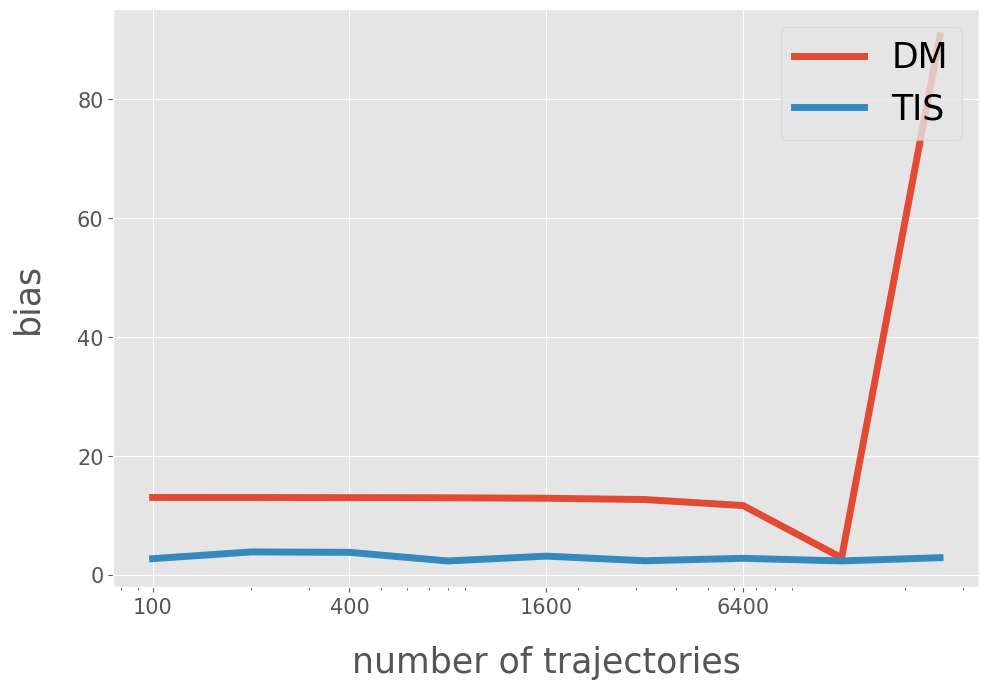

In [62]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'tis')and num_data <= 6400"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_70704/2084000416.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


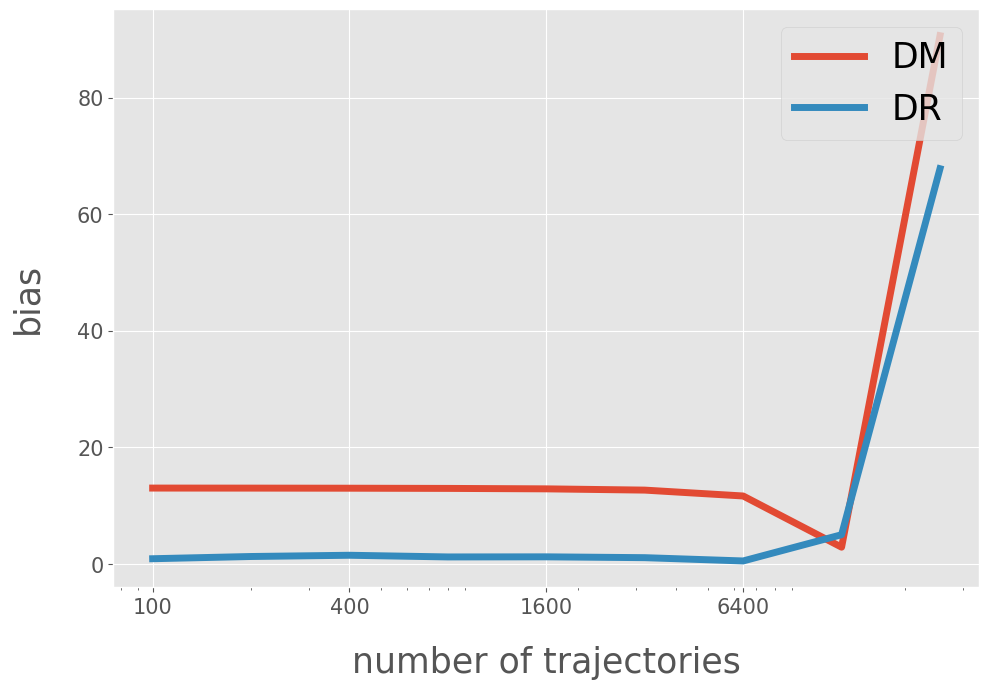

In [63]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [64]:
variance_result_df

,index,est,variance,n_trajectories
0,dm,0,0.014763,100
1,dr,0,0.471468,100
2,drl,0,0.014601,100
3,on_policy,0,0.064765,100
4,pdis,0,0.486707,100
...,...,...,...,...
148,sm_snis,0,0.000000,25600
149,sndr,0,3.679266,25600
150,snpdis,0,0.001403,25600
151,sntis,0,0.094222,25600


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_70704/3711746799.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


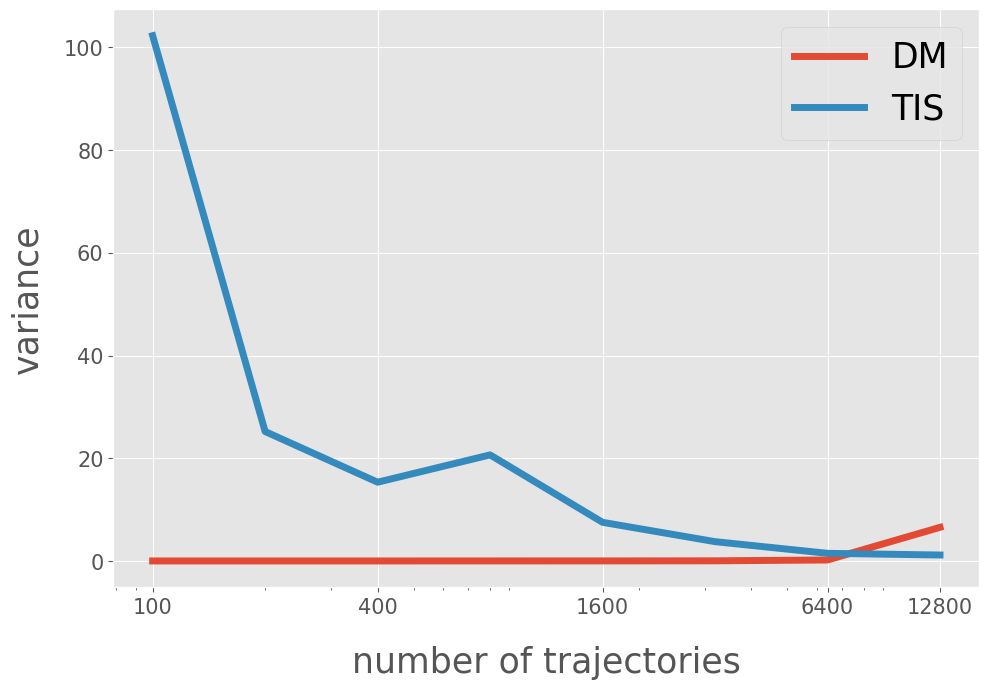

In [75]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400, 12800]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'tis') and n_trajectories <= 12800"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_70704/2997964467.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


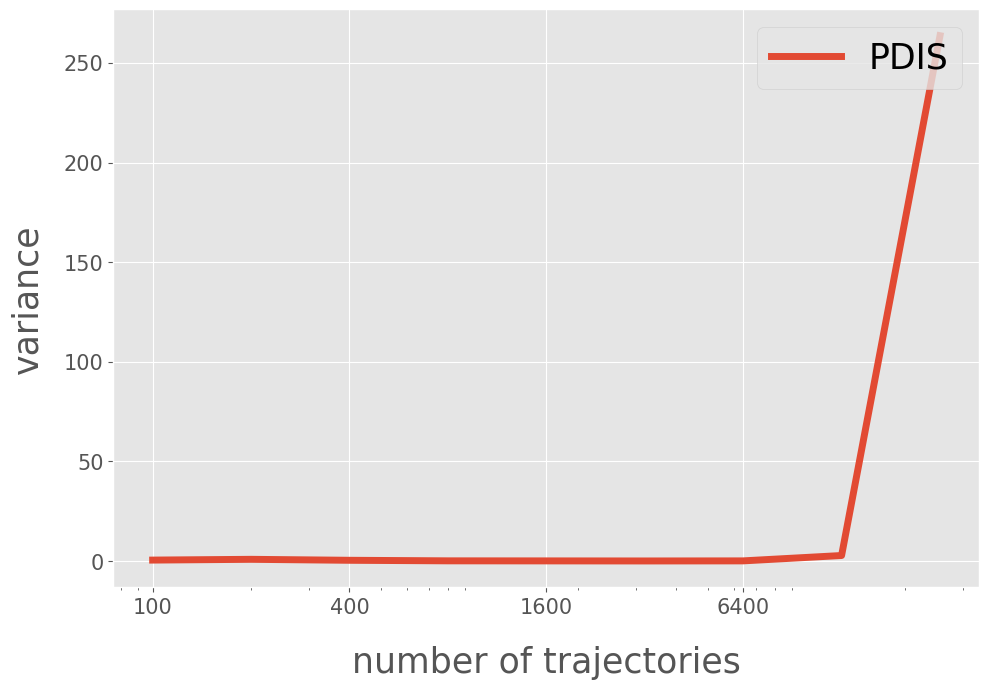

In [80]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'tis')"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_70704/79488338.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


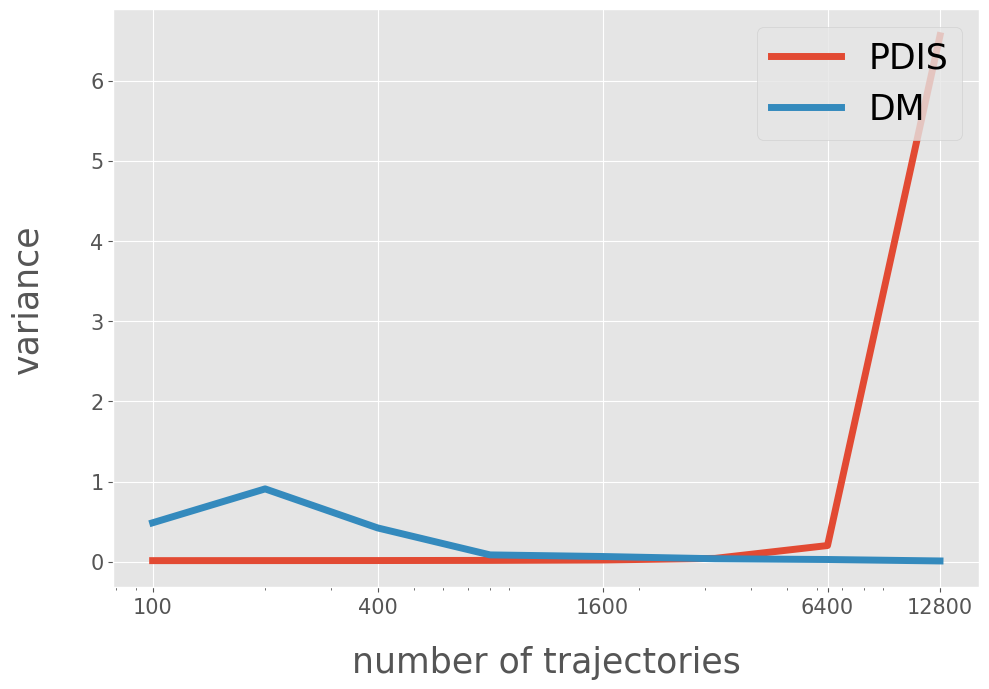

In [74]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400, 12800]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'dm')  and n_trajectories <= 12800"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "DM"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_70704/1241820721.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


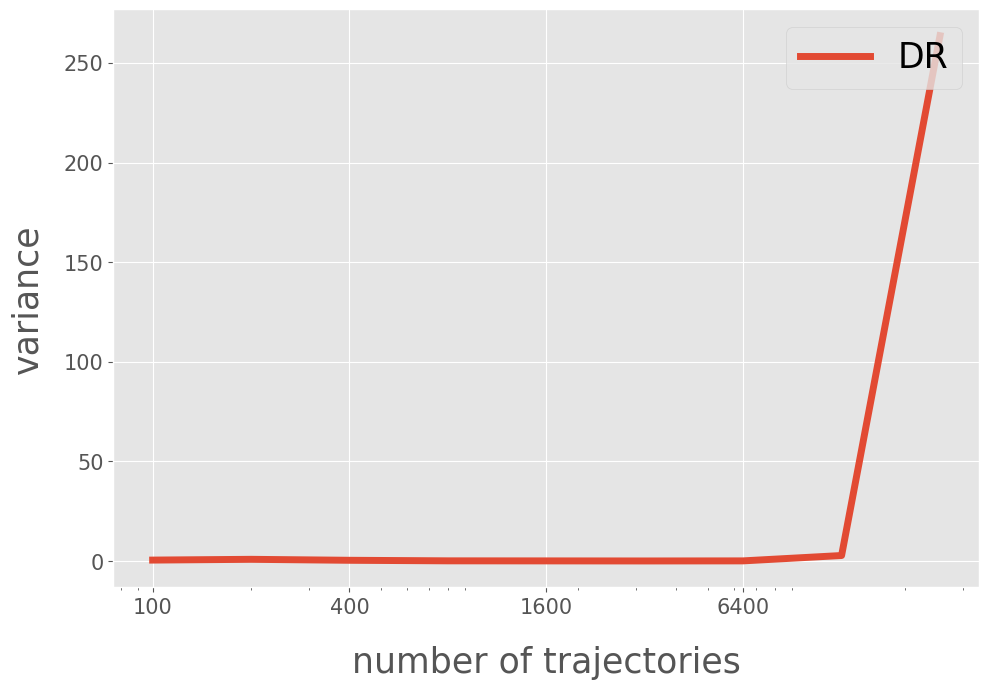

In [85]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    # data=variance_result_df.query("(index == 'pdis' or index == 'dm') and n_trajectories <= 12800"),
    data=variance_result_df.query("(index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)